In [1]:
import sys

import clip
import numpy as np
import pandas as pd
import torch
from sklearn import metrics

sys.path.append('/Users/hanselblanco/Documents/4to/ML/project/bias-project-ML')
from clip_execution import run_clip
from metrics import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [3]:
model.load_state_dict(torch.load("/Users/hanselblanco/Documents/4to/ML/project/bias-project-ML/debiased_clip/finetuning/pytorch/best_model/best_model.pt"))

<All keys matched successfully>

In [4]:
MALE = 'male'
FEMALE = 'female'
GENDER_LABELS = [MALE, FEMALE]
GENDER_TKNS = ['This is a person of' + gender_label + 'gender.' for gender_label in GENDER_LABELS ]
TEST_DF = pd.read_json('/Users/hanselblanco/Documents/4to/ML/project/bias-project-ML/test_data.json')

In [5]:
# Fix some file paths
for i in range(len(TEST_DF['filepath'])):
    TEST_DF['filepath'][i] = TEST_DF['filepath'][i].replace('(1)', '').replace(' ', '')

/var/folders/pl/9yyv_2w13q53qr62j77xxb_c0000gn/T/ipykernel_44108/3528695110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEST_DF['filepath'][i] = TEST_DF['filepath'][i].replace('(1)', '').replace(' ', '')


In [6]:
df = run_clip(['gender'], [GENDER_LABELS], [GENDER_TKNS], TEST_DF, model)

In [7]:
df.sample(20)

,filename,filepath,age,gender,race,predicted_gender
2084,3_1_0_20161220221915922.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,3,female,white,female
4550,19_1_0_20170116205908124.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,19,female,white,female
1855,37_0_1_20170117191953052.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,37,male,black,male
2166,3_0_2_20161219204727005.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,3,male,asian,female
521,67_1_0_20170110120952264.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,67,female,white,female
2734,2_1_4_20161221202110987.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,2,female,other,female
195,85_1_0_20170111205811953.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,85,female,white,male
747,60_1_0_20170110141547583.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,60,female,white,female
2899,28_1_2_20170116165530274.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,28,female,asian,female
2967,29_0_0_20170119195323402.jpg.chip.jpg,/Users/hanselblanco/Documents/4to/ML/project/b...,29,male,white,male


In [8]:
y_true=df['gender'].tolist()
y_pred=df['predicted_gender'].tolist()

In [9]:
male_total=df['gender'].value_counts()[MALE]
female_total= df['gender'].value_counts()[FEMALE]

#### Balanced Accuracy

In [10]:
macro_accuracy= macro_accuracy(y_true, y_pred)
macro_accuracy

0.9291200580240214

#### F1 score (macro)

F1 score can be interpreted as a measure of overall model performance from 0 to 1, where 1 is the best. To be more specific, F1 score can be interpreted as the model’s balanced ability to both capture positive cases (recall) and be accurate with the cases it does capture (precision).

the model’s ability to both capture positive cases and be accurate with the cases it does capture

In [11]:
macro_f1(y_true, y_pred, labels = GENDER_LABELS)

0.9286808847463958

#### Confusion Matrix

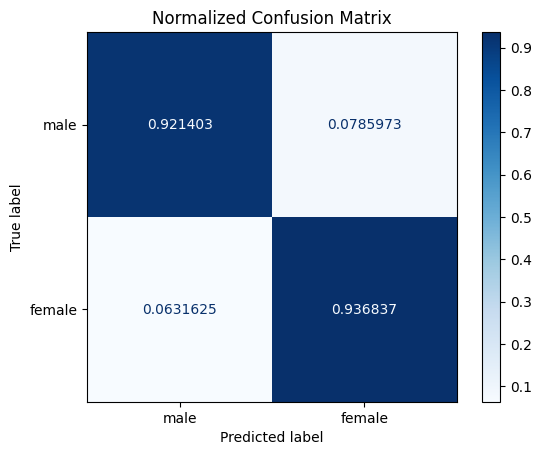

In [12]:

confusion_matrix = confusion_matrix(y_true, y_pred, labels = GENDER_LABELS)

#### Selection rate

In [13]:
srs = selection_rate(y_true, y_pred, GENDER_LABELS)
males_sr = srs[MALE]
females_sr = srs[FEMALE]
males_sr, females_sr

(0.0003713835792896631, 0.00041379746282260986)

#### TPR

In [14]:
tprs = tpr(y_true, y_pred, GENDER_LABELS)

males_tpr = tprs[MALE]
females_tpr = tprs[FEMALE]

males_tpr, females_tpr

(0.9214026602176542, 0.9368374558303887)

#### FPR

In [15]:
fprs = fpr(y_true, y_pred, GENDER_LABELS)

males_fpr = fprs[MALE]
females_fpr = fprs[FEMALE]

males_fpr, females_fpr

(0.06316254416961131, 0.07859733978234584)

### `Fairness Metrics`

#### Equalized Odds

In [18]:
eo = equalized_odds(y_true, y_pred, GENDER_LABELS)

EQUALIZED ODDS
Equalized odds
RESULTS:  {'male--female': {'tpr': 0.015434795612734531, 'fpr': 0.015434795612734531}}


#### Disparate impact

In [17]:
di = disparate_impact(y_true, y_pred, GENDER_LABELS)

DISPARATE IMPACT.
No disparate impact present
RESULTS:  {'male/female': 0.897500861306322}
